In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/final-dataset/final_dataset.csv
/kaggle/input/anomaly-detection-sintetico-dataset/final_dataset.csv


In [2]:
import pandas as pd
import numpy as np

train_data = pd.read_csv('/kaggle/input/anomaly-detection-sintetico-dataset/final_dataset.csv')

print("Train Data Shape:", train_data.shape)

print(train_data.head())

Train Data Shape: (2000, 7)
   user_id            timestamp     access_type        resource  \
0        7  2023-02-21 16:15:00  network_access  network_device   
1        8  2023-02-22 10:45:00  authentication    server_login   
2        1  2023-02-23 13:30:00     data_access  database_query   
3        3  2023-02-24 09:00:00     file_access   file_download   
4        4  2023-02-25 16:15:00  network_access  network_device   

               action_detail    ip_address    label  
0  Network traffic monitored     10.0.0.28   normal  
1           Login successful  192.168.1.27   normal  
2              Data accessed     10.0.0.29  anomaly  
3            File downloaded  192.168.1.28   normal  
4  Network traffic monitored     10.0.0.30   normal  


In [3]:
print("Total observations:", len(train_data))
print("Users:", train_data['user_id'].nunique())
print("Access type:", train_data['access_type'].nunique())
print("Resource:", train_data['resource'].nunique())
print("Action:", train_data['action_detail'].nunique())
print("IP Address:", train_data['ip_address'].nunique())

Total observations: 2000
Users: 1953
Access type: 4
Resource: 5
Action: 6
IP Address: 1489


In [4]:
train_data['label'].value_counts()


label
normal     1286
anomaly     714
Name: count, dtype: int64

In [5]:
train_data[train_data['label'] == 'normal'][:5]

,user_id,timestamp,access_type,resource,action_detail,ip_address,label
0,7,2023-02-21 16:15:00,network_access,network_device,Network traffic monitored,10.0.0.28,normal
1,8,2023-02-22 10:45:00,authentication,server_login,Login successful,192.168.1.27,normal
3,3,2023-02-24 09:00:00,file_access,file_download,File downloaded,192.168.1.28,normal
4,4,2023-02-25 16:15:00,network_access,network_device,Network traffic monitored,10.0.0.30,normal
5,5,2023-02-26 10:45:00,authentication,server_login,Login successful,192.168.1.29,normal


In [6]:
train_data.isna().sum()


user_id          0
timestamp        0
access_type      0
resource         0
action_detail    0
ip_address       0
label            0
dtype: int64

In [7]:
# Convert 'time' column to datetime and sort by time
train_data['timestamp'] = pd.to_datetime(train_data['timestamp'], format='%Y-%m-%d %H:%M:%S', errors='coerce')  
train_data = train_data.sort_values(by='timestamp') 
# Temporal range of the dataset
start_time = train_data['timestamp'].min()
end_time = train_data['timestamp'].max()

print(f"First observation: {start_time}\nLatest observation: {end_time}")
print("Total observations:", len(train_data))
print("Users:", train_data['user_id'].nunique())


First observation: 2023-01-01 00:00:00
Latest observation: 2023-12-31 14:20:00
Total observations: 2000
Users: 1953


In [8]:
#2. Filter Data to Select Specific Users

# Select a subset of users
unique_users = train_data['user_id'].unique()
selected_users = np.random.choice(unique_users, 1953, replace=False)
filtered_df = train_data[train_data['user_id'].isin(selected_users)]


In [9]:
print("Total observations:", len(filtered_df))
print("Users:", filtered_df['user_id'].nunique())
print("Unique IPs:", filtered_df['ip_address'].nunique())
print("Access type:",  filtered_df['access_type'].nunique())
print("Resource:",  filtered_df['resource'].nunique())
print("Action:",  filtered_df['action_detail'].nunique())


Total observations: 2000
Users: 1953
Unique IPs: 1489
Access type: 4
Resource: 5
Action: 6


In [10]:
filtered_df.shape

(2000, 7)

**Filter Data to Select Specific Time Ranges**

In [11]:
start_date = '2023-01-01'
end_date = '2023-12-31'

# Filter data within the time range
sample_df = filtered_df[filtered_df['timestamp'].between(start_date, end_date)]
sample_df.set_index('timestamp', inplace=True, drop=False)

print("Total observations:", len(sample_df))
print("Unique users:", sample_df['user_id'].nunique())
print("Action:", sample_df['action_detail'].nunique())
print("Access type:", sample_df['access_type'].nunique())
print("Resource:", sample_df['resource'].nunique())
print("Unique IPs:", sample_df['ip_address'].nunique())



Total observations: 1997
Unique users: 1950
Action: 6
Access type: 4
Resource: 5
Unique IPs: 1489


In [12]:
sample_df.columns

Index(['user_id', 'timestamp', 'access_type', 'resource', 'action_detail',
       'ip_address', 'label'],
      dtype='object')

In [13]:
sample_df = sample_df.drop(columns=['user_id'])
sample_df.shape

categorical_features=[feature for feature in sample_df.columns if sample_df[feature].dtypes=='O']
categorical_features




['access_type', 'resource', 'action_detail', 'ip_address', 'label']

In [14]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Apply LabelEncoder to each categorical column
for feature in categorical_features:
    sample_df[feature + '_encoded'] = le.fit_transform(sample_df[feature])
sample_df.head(3)

,timestamp,access_type,resource,action_detail,ip_address,label,access_type_encoded,resource_encoded,action_detail_encoded,ip_address_encoded,label_encoded
timestamp,,,,,,,,,,,
2023-01-01 00:00:00,2023-01-01 00:00:00,authentication,server_login,Login successful,10.0.0.518,normal,0,4,4,432,1
2023-01-01 01:15:00,2023-01-01 01:15:00,data_access,database_query,Data accessed,192.168.1.519,normal,1,0,0,1165,1
2023-01-01 02:30:00,2023-01-01 02:30:00,file_access,file_download,File downloaded,10.0.0.520,normal,2,1,1,435,1


In [15]:
# Drop the original categorical columns 
sample_df = sample_df.drop(columns=categorical_features)
sample_df.head(5)

,timestamp,access_type_encoded,resource_encoded,action_detail_encoded,ip_address_encoded,label_encoded
timestamp,,,,,,
2023-01-01 00:00:00,2023-01-01 00:00:00,0,4,4,432,1
2023-01-01 01:15:00,2023-01-01 01:15:00,1,0,0,1165,1
2023-01-01 02:30:00,2023-01-01 02:30:00,2,1,1,435,1
2023-01-01 03:45:00,2023-01-01 03:45:00,3,3,5,1168,1
2023-01-01 05:00:00,2023-01-01 05:00:00,0,4,4,437,0


**Pre-processing of Time column**

In [16]:
# Extract numerical features

sample_df['hour'] = sample_df['timestamp'].dt.hour
sample_df['day_of_week'] = sample_df['timestamp'].dt.day_of_week
sample_df['month'] = sample_df['timestamp'].dt.month
sample_df.drop('timestamp', axis=1, inplace=True)
sample_df.head(4)

,access_type_encoded,resource_encoded,action_detail_encoded,ip_address_encoded,label_encoded,hour,day_of_week,month
timestamp,,,,,,,,
2023-01-01 00:00:00,0,4,4,432,1,0,6,1
2023-01-01 01:15:00,1,0,0,1165,1,1,6,1
2023-01-01 02:30:00,2,1,1,435,1,2,6,1
2023-01-01 03:45:00,3,3,5,1168,1,3,6,1



5.3 Robust Scaling

- scales the features using statistics that are robust to outliers, such as the median and the interquartile range (IQR).
- resistant to the influence of outliers compared to standard scaling techniques like Min-Max Scaling or Standard Scaling.

In [17]:
from sklearn.preprocessing import RobustScaler

# Create a RobustScaler object
robust_scaler = RobustScaler()

# Fit and transform the DataFrame
scaled_df = pd.DataFrame(robust_scaler.fit_transform(sample_df), columns=sample_df.columns)

print("Original DataFrame:")
print(sample_df)
print("\nScaled DataFrame:")
print(scaled_df)

Original DataFrame:
                     access_type_encoded  resource_encoded  \
timestamp                                                    
2023-01-01 00:00:00                    0                 4   
2023-01-01 01:15:00                    1                 0   
2023-01-01 02:30:00                    2                 1   
2023-01-01 03:45:00                    3                 3   
2023-01-01 05:00:00                    0                 4   
...                                  ...               ...   
2023-12-28 20:55:00                    0                 4   
2023-12-29 03:20:00                    1                 0   
2023-12-29 16:16:00                    1                 0   
2023-12-30 09:45:00                    2                 1   
2023-12-30 23:31:00                    2                 1   

                     action_detail_encoded  ip_address_encoded  label_encoded  \
timestamp                                                                       
2023-01-01 

**6. Feature Extraction**

- Identify the most significative variables of the dataset.

**6.1 Correlation Matrix**

- Features with high correlation coefficients are likely to be more important.

In [18]:
# Get the feature names from the original DataFrame
original_feature_names = sample_df.columns

# Apply correlation matrix 
corr_matrix = scaled_df.corr()

# Create a mapping dictionary
feature_mapping = {f'feature{i+1}': original_feature_names[i] for i in range(len(original_feature_names))}
# Rename the columns in the correlation matrix
corr_matrix = corr_matrix.rename(columns=feature_mapping, index=feature_mapping)
corr_matrix

,access_type_encoded,resource_encoded,action_detail_encoded,ip_address_encoded,label_encoded,hour,day_of_week,month
access_type_encoded,1.000000,-0.143579,0.215435,-0.300160,0.018133,0.021770,0.007468,0.002990
resource_encoded,-0.143579,1.000000,0.919908,0.214508,0.072180,0.015201,-0.001736,0.000430
action_detail_encoded,0.215435,0.919908,1.000000,0.004120,0.039300,-0.003272,-0.002004,0.002614
ip_address_encoded,-0.300160,0.214508,0.004120,1.000000,0.100299,0.125386,-0.035080,-0.104914
label_encoded,0.018133,0.072180,0.039300,0.100299,1.000000,0.031797,0.003259,0.034653
hour,0.021770,0.015201,-0.003272,0.125386,0.031797,1.000000,0.028464,0.032841
day_of_week,0.007468,-0.001736,-0.002004,-0.035080,0.003259,0.028464,1.000000,-0.009371
month,0.002990,0.000430,0.002614,-0.104914,0.034653,0.032841,-0.009371,1.000000


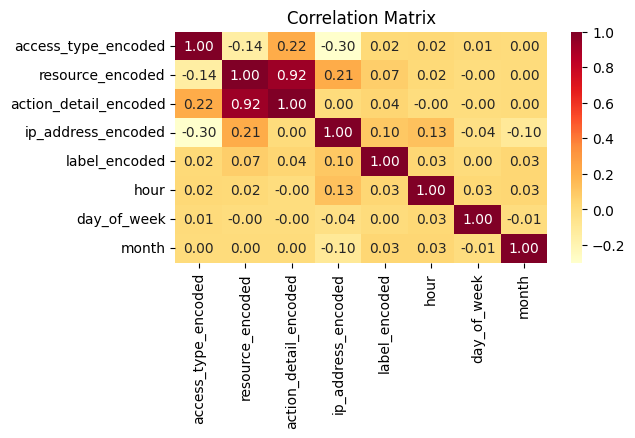

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))
sns.heatmap(corr_matrix, annot=True, cmap='YlOrRd', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [20]:
# scaled_df = scaled_df.drop('month', axis=1)
# scaled_df.columns

**DBSCAN**

In [21]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClusterMixin

class DBSCANWrapper(BaseEstimator, ClusterMixin):
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        self.dbscan = DBSCAN(eps=self.eps, min_samples=self.min_samples)
    
    def fit(self, X, y=None):
        self.dbscan.fit(X)
        return self
    
    def fit_predict(self, X, y=None):
        return self.dbscan.fit_predict(X)
    
def silhouette_scorer(estimator, X):
    clusters = estimator.fit_predict(X)
    if len(set(clusters)) > 1:
        score = silhouette_score(X, clusters)
    else:
        score = -1  # or some other value to indicate that the score isn't valid
    return score


param_grid = {
    'eps': [0.2, 0.5, 0.7, 1.0],
    'min_samples': [3, 5, 10, 12, 15]
}

dbscan = DBSCANWrapper()
grid_search = GridSearchCV(estimator=dbscan, param_grid=param_grid, scoring=silhouette_scorer, cv=3)

grid_search.fit(scaled_df)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\nBest Parameters: {best_params} - Best Silhouette Score: {best_score}")



Best Parameters: {'eps': 0.2, 'min_samples': 3} - Best Silhouette Score: 0.2003553131404698


**Retrain the model with the best parameters.**

In [22]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN
epsilon = 0.2
min_samples=3
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
clusters = dbscan.fit_predict(scaled_df)

**Identify the core and the outliers for DBSCAN**

In [23]:
import numpy as np

core_samples = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples[dbscan.core_sample_indices_] = True
labels = dbscan.labels_
# Check the number of clusters after DBSCAN algorithm (ignoring noise if present)

n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')

Estimated number of clusters: 193
Estimated number of noise points: 816


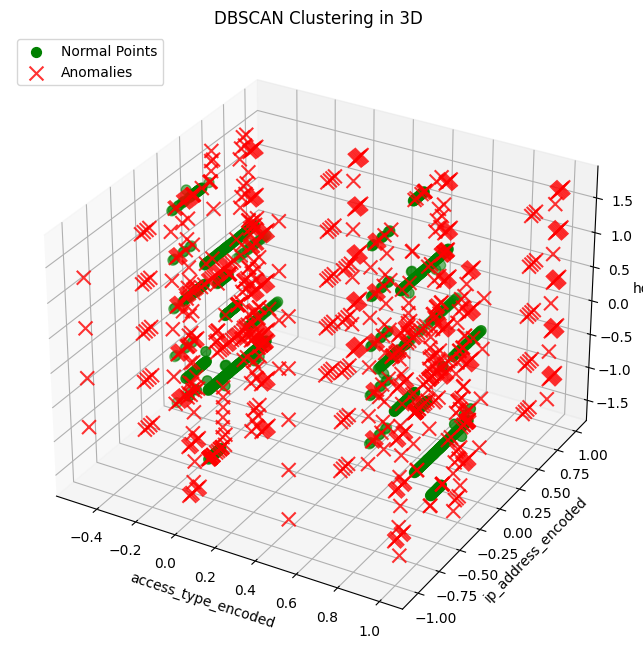

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
import numpy as np

X = scaled_df[['access_type_encoded', 'ip_address_encoded', 'hour']].values
 

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the normal (clustered) points in blue
normal_points = ax.scatter(X[labels != -1, 0], X[labels != -1, 1], X[labels != -1, 2], c='green', s=50)

# Plot the anomalies (noise points) in red with 'x' markers
anomalies = ax.scatter(X[labels == -1, 0], X[labels == -1, 1], X[labels == -1, 2], marker='x', c='#FF0000', s=100, alpha=0.8)

# # plot the failed points
# failed_points = ax.scatter(X[labels == 1, 0], X[labels == 1, 1], X[labels == 1, 2], marker='o', c='blue', s=100, alpha=0.8, label='Failed')

# Set labels and title
ax.set_xlabel('access_type_encoded')
ax.set_ylabel('ip_address_encoded')
ax.set_zlabel('hour')
ax.set_title('DBSCAN Clustering in 3D')

# Add a legend
ax.legend([normal_points, anomalies], ['Normal Points', 'Anomalies'], loc='upper left')

plt.show()

### 8. Isolation forest
8.1 Hyperparamter tuning

Contamination: This is a parameter that the algorithm is quite sensitive to; it refers to the expected proportion of outliers in the data set. This is used when fitting to define the threshold on the scores of the samples.

In [25]:
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest

# Custom scoring function for unsupervised learning
def unsupervised_scorer(estimator, X):
    # Predict the anomaly scores
    scores_pred = estimator.decision_function(X)
    
     # Classify points as normal or anomalous based on the contamination threshold
    labels = scores_pred < estimator.contamination
    
    # Compute the silhouette score
    try:
        silhouette = silhouette_score(X, labels)
        # Check if the silhouette score is NaN
        if np.isnan(silhouette):
            return -1  # Return a default value for NaN (you can choose another value if preferred)
        return silhouette
    except ValueError:
        # Handle cases where silhouette score cannot be computed
        return -1  # Return a default value for errors
    
    
    
    # Compute the silhouette score
    silhouette = silhouette_score(X, scores_pred < estimator.contamination)
    return silhouette

# Initialize the Isolation Forest model with contamination parameter
iso_forest = IsolationForest(contamination=0.01, random_state=42)

# Define a range of parameters to tune, excluding the contamination parameter
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_samples': [0.25, 0.5, 0.75],
    'max_features': [1.0, 0.7, 0.5]
}

X = scaled_df[['access_type_encoded', 'ip_address_encoded', 'hour']].values

# Set up the grid search with the custom scorer
grid_search = GridSearchCV(estimator=iso_forest, param_grid=param_grid, scoring=unsupervised_scorer, cv=5, n_jobs=-1)

# Fit the model
grid_search.fit(X)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

# the best estimator for further analysis
best_iso_forest = grid_search.best_estimator_

Best parameters: {'max_features': 0.5, 'max_samples': 0.75, 'n_estimators': 100}
Best score: 0.19994260410662826


In [26]:
from sklearn.ensemble import IsolationForest

# Retrain the model with the best hyperparameters

iso_forest = IsolationForest(**grid_search.best_params_)
iso_labels = iso_forest.fit_predict(scaled_df)
n_clusters_ = len(set(iso_labels)) - (1 if -1 in iso_labels else 0)
n_noise_ = list(iso_labels).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')

Estimated number of clusters: 1
Estimated number of noise points: 1412


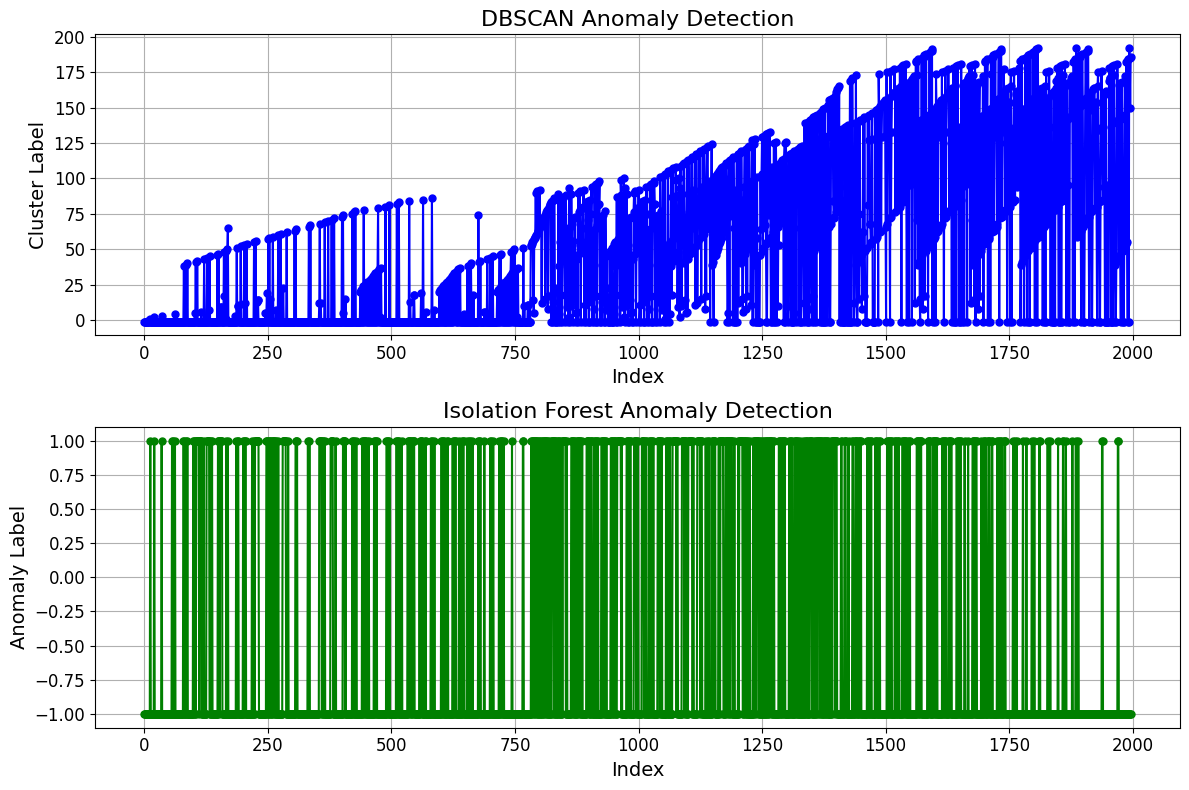

In [27]:
import matplotlib.pyplot as plt

# Create a figure with a specified size
plt.figure(figsize=(12, 8))

# Plot DBSCAN labels
plt.subplot(2, 1, 1)
plt.plot(scaled_df.index, clusters, marker='o', linestyle='-', color='b', markersize=5)
plt.title('DBSCAN Anomaly Detection', fontsize=16)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Cluster Label', fontsize=14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Plot Isolation Forest labels
plt.subplot(2, 1, 2)
plt.plot(scaled_df.index, iso_labels, marker='o', linestyle='-', color='g', markersize=5)
plt.title('Isolation Forest Anomaly Detection', fontsize=16)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Anomaly Label', fontsize=14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

GPT2 MODEL

In [28]:
# from transformers import GPT2LMHeadModel, GPT2Tokenizer

# # Carica il modello GPT-2 pre-addestrato
# model = GPT2LMHeadModel.from_pretrained('gpt2')
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# # Definisci gli schemi per le colonne del dataset
# schema = "user_id,timestamp,access_type,resource,action_detail,label\n"
# prompts = {
#     'user_id': "Genera un ID utente univoco: ",
#     'timestamp': "Genera un timestamp nel formato YYYY-MM-DD HH:MM:SS: ",
#     # Definisci altri prompt per le colonne
# }

# # Genera il dataset
# num_records = 1000
# for _ in range(num_records):
#     record = []
#     for column, prompt in prompts.items():
#         # Genera testo usando il modello GPT-2
#         input_ids = tokenizer.encode(prompt, return_tensors='pt')
#         output = model.generate(input_ids, max_length=50, num_return_sequences=1, do_sample=True)[0]
#         generated_text = tokenizer.decode(output, skip_special_tokens=True)
#         record.append(generated_text.strip())
    
#     # Unisci il record in una stringa separata da virgole
#     record_str = ','.join(record) + '\n'
#     schema += record_str

# # Salva il dataset in un file CSV
# with open('synthetic_user_access_logs.csv', 'w', newline='') as csvfile:
#     csvfile.write(schema)


In [29]:
# import pandas as pd
# import random
# from transformers import GPT2LMHeadModel, GPT2Tokenizer

# # Load the pre-trained GPT-2 model and tokenizer
# model_name = 'gpt2'  # You can also use 'gpt2-medium' or other variants
# model = GPT2LMHeadModel.from_pretrained(model_name)
# tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# # Function to generate text using the LLM
# def generate_text(prompt):
#     input_ids = tokenizer.encode(prompt, return_tensors='pt')
#     output = model.generate(input_ids, max_length=50, num_return_sequences=1, do_sample=True)
#     generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
#     return generated_text.strip()

# # Define the dataset structure
# num_records = 1000
# data = []

# # Predefined actions and labels for anomalies
# actions_normal = [
#     "Login", 
#     "Logged In", 
#     "Downloaded Document", 
#     "Logged Out", 
#     "Password Reset"
# ]

# actions_anomaly = [
#     "Accessed Sensitive Data", 
#     "Attempted Unauthorized Access", 
#     "Attempted SQL Injection", 
#     "Unauthorized Access"
# ]

# # Generate synthetic dataset
# for i in range(num_records):
#     user_id = f"U{random.randint(100, 999)}"  # Random user ID
#     timestamp = f"2023-01-01 {random.randint(8, 10):02d}:{random.randint(0, 59):02d}:00"  # Random timestamp
#     if random.random() < 0.3:  # 30% chance of being an anomaly
#         action = random.choice(actions_anomaly)
#         label = "Anomaly"
#     else:
#         action = random.choice(actions_normal)
#         label = "Normal"
    
#     # Append the generated record to the dataset
#     data.append([timestamp, user_id, action, label])

# # Create a DataFrame
# df = pd.DataFrame(data, columns=["Timestamp", "User ID", "Action", "Label"])

# # Display the first few rows of the synthetic dataset
# print(df.head())

# # Save the synthetic dataset to a CSV file
# df.to_csv('synthetic_anomaly_user_behavior.csv', index=False)
